IST 664 - Final Project

Text Classification with Kaggle Movie Reviews

Andrew Krick

In [1]:
# Import & Setup
import csv
import random
import re
from collections import Counter, defaultdict

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Run once
nltk.download("punkt")
nltk.download("stopwords")

TRAIN_PATH = "train.tsv"

SAMPLES_PER_CLASS = 1000
TOP_N_RAW_VOCAB = 3000
TOP_N_CLEAN_VOCAB = 3000
NUM_FOLDS = 5
RANDOM_SEED = 42

ENGLISH_STOPWORDS = set(stopwords.words("english"))

RAW_VOCAB = []
CLEAN_VOCAB = []

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# Load Data and subset

def load_kaggle_movie_data(path):
    by_label = defaultdict(list)

    with open(path, encoding="utf8") as f:
        reader = csv.DictReader(f, delimiter="\t")
        for row in reader:
            phrase = row["Phrase"]
            label = int(row["Sentiment"])
            by_label[label].append((phrase, label))

    return by_label


def create_balanced_subset(by_label, samples_per_class=SAMPLES_PER_CLASS, seed=RANDOM_SEED):
    random.seed(seed)
    subset = []

    for label in sorted(by_label.keys()):
        examples = by_label[label]
        if len(examples) <= samples_per_class:
            chosen = examples
        else:
            chosen = random.sample(examples, samples_per_class)
        subset.extend(chosen)

    random.shuffle(subset)
    return subset

In [3]:
# Tokenization and cleaning.

def tokenize_raw(text):
    return word_tokenize(text)


def tokenize_and_clean(text):
    tokens = word_tokenize(text)
    cleaned = []

    for tok in tokens:
        tok_lower = tok.lower()

        if re.fullmatch(r"\W+", tok_lower):
            continue

        if tok_lower in ENGLISH_STOPWORDS:
            continue

        cleaned.append(tok_lower)

    return cleaned

In [4]:
# Build Vocabularies

def build_vocab_from_tokens(list_of_token_lists, top_n):
    counter = Counter()
    for tokens in list_of_token_lists:
        counter.update(tokens)

    most_common = [w for (w, _) in counter.most_common(top_n)]
    return most_common

In [5]:
# Feature functions - Baseline, Clean, New Feature

def baseline_features(text):
    tokens = tokenize_raw(text)
    token_set = set(tokens)

    feats = {}
    for w in RAW_VOCAB:
        feats[f"has({w})"] = (w in token_set)
    return feats


def cleaned_features(text):
    tokens = tokenize_and_clean(text)
    token_set = set(tokens)

    feats = {}
    for w in CLEAN_VOCAB:
        feats[f"has_clean({w})"] = (w in token_set)
    return feats


def cleaned_plus_emphasis_features(text):
    cleaned_tokens = tokenize_and_clean(text)
    token_set = set(cleaned_tokens)

    feats = {}
    for w in CLEAN_VOCAB:
        feats[f"has_clean({w})"] = (w in token_set)

    raw_tokens = word_tokenize(text)

    count_all_caps = 0
    count_elongated = 0

    for tok in raw_tokens:
        if tok.isalpha() and tok.isupper() and len(tok) > 1:
            count_all_caps += 1
        if re.search(r"(.)\1\1+", tok.lower()):
            count_elongated += 1

    feats["count_all_caps"] = float(count_all_caps)
    feats["count_elongated"] = float(count_elongated)
    feats["token_length"] = float(len(cleaned_tokens))

    return feats

In [6]:
# Metrics

def compute_metrics(gold_labels, pred_labels):
    assert len(gold_labels) == len(pred_labels)
    n = len(gold_labels)

    correct = sum(1 for g, p in zip(gold_labels, pred_labels) if g == p)
    accuracy = correct / n if n > 0 else 0.0

    labels = sorted(set(gold_labels))
    tp = {l: 0 for l in labels}
    fp = {l: 0 for l in labels}
    fn = {l: 0 for l in labels}

    for g, p in zip(gold_labels, pred_labels):
        if g == p:
            tp[g] += 1
        else:
            fp[p] += 1
            fn[g] += 1

    precisions = []
    recalls = []
    f1s = []

    for l in labels:
        p = tp[l] / (tp[l] + fp[l]) if (tp[l] + fp[l]) > 0 else 0.0
        r = tp[l] / (tp[l] + fn[l]) if (tp[l] + fn[l]) > 0 else 0.0
        f1 = (2 * p * r / (p + r)) if (p + r) > 0 else 0.0

        precisions.append(p)
        recalls.append(r)
        f1s.append(f1)

    macro_precision = sum(precisions) / len(precisions) if precisions else 0.0
    macro_recall = sum(recalls) / len(recalls) if recalls else 0.0
    macro_f1 = sum(f1s) / len(f1s) if f1s else 0.0

    return accuracy, macro_precision, macro_recall, macro_f1

In [7]:
# Cross-validation

def cross_validate(examples, feature_func, num_folds=NUM_FOLDS, seed=RANDOM_SEED):
    random.seed(seed)
    exs = examples[:]
    random.shuffle(exs)

    fold_size = len(exs) // num_folds
    metrics_per_fold = []

    for fold in range(num_folds):
        start = fold * fold_size
        end = len(exs) if fold == num_folds - 1 else (fold + 1) * fold_size

        test = exs[start:end]
        train = exs[:start] + exs[end:]

        train_set = [(feature_func(text), label) for (text, label) in train]
        test_set = [(feature_func(text), label) for (text, label) in test]

        classifier = nltk.NaiveBayesClassifier.train(train_set)

        gold = []
        pred = []
        for feats, label in test_set:
            gold.append(label)
            pred.append(classifier.classify(feats))

        acc, p_macro, r_macro, f1_macro = compute_metrics(gold, pred)
        metrics_per_fold.append((acc, p_macro, r_macro, f1_macro))

        print(f"Fold {fold + 1}/{num_folds}: Acc={acc:.3f}, P={p_macro:.3f}, R={r_macro:.3f}, F1={f1_macro:.3f}")

    avg_acc = sum(m[0] for m in metrics_per_fold) / num_folds
    avg_p = sum(m[1] for m in metrics_per_fold) / num_folds
    avg_r = sum(m[2] for m in metrics_per_fold) / num_folds
    avg_f1 = sum(m[3] for m in metrics_per_fold) / num_folds

    return avg_acc, avg_p, avg_r, avg_f1

In [8]:
# Run all - Build Vocabularies and experoments.
nltk.download('punkt_tab')

by_label = load_kaggle_movie_data(TRAIN_PATH)

print("Full dataset label counts:")
for label in sorted(by_label.keys()):
    print(label, len(by_label[label]))

subset = create_balanced_subset(by_label, SAMPLES_PER_CLASS)
print("Subset size:", len(subset))

texts = [t for (t, lab) in subset]
labels = [lab for (t, lab) in subset]
examples = list(zip(texts, labels))

raw_token_lists = [tokenize_raw(t) for t in texts]
clean_token_lists = [tokenize_and_clean(t) for t in texts]

RAW_VOCAB = build_vocab_from_tokens(raw_token_lists, TOP_N_RAW_VOCAB)
CLEAN_VOCAB = build_vocab_from_tokens(clean_token_lists, TOP_N_CLEAN_VOCAB)

print("RAW_VOCAB size:", len(RAW_VOCAB))
print("CLEAN_VOCAB size:", len(CLEAN_VOCAB))

print("\nExperiment 1: Baseline raw unigrams")
acc1, p1, r1, f1_1 = cross_validate(examples, baseline_features)
print("Averages:", acc1, p1, r1, f1_1)

print("\nExperiment 2: Cleaned unigrams")
acc2, p2, r2, f1_2 = cross_validate(examples, cleaned_features)
print("Averages:", acc2, p2, r2, f1_2)

print("\nExperiment 3: Cleaned + emphasis (new feature)")
acc3, p3, r3, f1_3 = cross_validate(examples, cleaned_plus_emphasis_features)
print("Averages:", acc3, p3, r3, f1_3)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Full dataset label counts:
0 7072
1 27273
2 79582
3 32927
4 9206
Subset size: 5000
RAW_VOCAB size: 3000
CLEAN_VOCAB size: 3000

Experiment 1: Baseline raw unigrams
Fold 1/5: Acc=0.405, P=0.424, R=0.409, F1=0.392
Fold 2/5: Acc=0.391, P=0.405, R=0.390, F1=0.375
Fold 3/5: Acc=0.403, P=0.433, R=0.404, F1=0.389
Fold 4/5: Acc=0.420, P=0.452, R=0.421, F1=0.405
Fold 5/5: Acc=0.404, P=0.421, R=0.402, F1=0.388
Averages: 0.4046 0.4272174249684227 0.40501081985212134 0.3898916240740718

Experiment 2: Cleaned unigrams
Fold 1/5: Acc=0.418, P=0.444, R=0.421, F1=0.410
Fold 2/5: Acc=0.397, P=0.419, R=0.396, F1=0.390
Fold 3/5: Acc=0.396, P=0.430, R=0.396, F1=0.388
Fold 4/5: Acc=0.409, P=0.442, R=0.410, F1=0.403
Fold 5/5: Acc=0.416, P=0.434, R=0.414, F1=0.406
Averages: 0.4072 0.43398352547820956 0.40753231488754793 0.39952574199436536

Experiment 3: Cleaned + emphasis (new feature)
Fold 1/5: Acc=0.422, P=0.442, R=0.425, F1=0.416
Fold 2/5: Acc=0.399, P=0.412, R=0.398, F1=0.390
Fold 3/5: Acc=0.409, P=0.430

In [9]:
# Load Subjectivity Lexicon
# Load once

SUBJ_LEX_PATH = "subjclueslen1-HLTEMNLP05.tff"

def load_subjectivity_lexicon(path):
    """
    Reads MPQA subjectivity clues file.
    Returns dict[word] -> dict with keys: type, priorpolarity
    Example line:
      type=strongsubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative
    """
    lex = {}
    with open(path, encoding="utf8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            fields = {}
            for p in parts:
                if "=" in p:
                    k, v = p.split("=", 1)
                    fields[k] = v
            w = fields.get("word1")
            if w:
                lex[w] = {
                    "type": fields.get("type", ""),
                    "priorpolarity": fields.get("priorpolarity", "")
                }
    return lex

SUBJ_LEX = load_subjectivity_lexicon(SUBJ_LEX_PATH)
print("Loaded subjectivity lexicon entries:", len(SUBJ_LEX))

Loaded subjectivity lexicon entries: 6885


Lexicon feature function - counts & simple score

In [10]:
def cleaned_plus_subjectivity_features(text):
    """
    Feature set:
    - cleaned unigrams (CLEAN_VOCAB)
    - subjectivity lexicon counts:
        strong_pos, strong_neg, weak_pos, weak_neg
        subj_pos_total, subj_neg_total, subj_score
    """
    cleaned_tokens = tokenize_and_clean(text)
    token_set = set(cleaned_tokens)

    feats = {}
    for w in CLEAN_VOCAB:
        feats[f"has_clean({w})"] = (w in token_set)

    strong_pos = 0
    strong_neg = 0
    weak_pos = 0
    weak_neg = 0

    for tok in cleaned_tokens:
        entry = SUBJ_LEX.get(tok)
        if not entry:
            continue

        typ = entry.get("type")
        pol = entry.get("priorpolarity")

        if typ == "strongsubj" and pol == "positive":
            strong_pos += 1
        elif typ == "strongsubj" and pol == "negative":
            strong_neg += 1
        elif typ == "weaksubj" and pol == "positive":
            weak_pos += 1
        elif typ == "weaksubj" and pol == "negative":
            weak_neg += 1

    pos_total = strong_pos + weak_pos
    neg_total = strong_neg + weak_neg

    feats["subj_strong_pos"] = float(strong_pos)
    feats["subj_strong_neg"] = float(strong_neg)
    feats["subj_weak_pos"] = float(weak_pos)
    feats["subj_weak_neg"] = float(weak_neg)
    feats["subj_pos_total"] = float(pos_total)
    feats["subj_neg_total"] = float(neg_total)

    # Simple score: (pos - neg), with strong counting as 2
    score = (2 * strong_pos + weak_pos) - (2 * strong_neg + weak_neg)
    feats["subj_score"] = float(score)

    return feats

Run Experiment 4

In [11]:
print("\nExperiment 4: Cleaned unigrams + Subjectivity lexicon features")
acc4, p4, r4, f1_4 = cross_validate(examples, cleaned_plus_subjectivity_features)
print("Averages:", acc4, p4, r4, f1_4)


Experiment 4: Cleaned unigrams + Subjectivity lexicon features
Fold 1/5: Acc=0.460, P=0.461, R=0.461, F1=0.452
Fold 2/5: Acc=0.452, P=0.450, R=0.451, F1=0.445
Fold 3/5: Acc=0.438, P=0.441, R=0.438, F1=0.434
Fold 4/5: Acc=0.463, P=0.468, R=0.465, F1=0.458
Fold 5/5: Acc=0.441, P=0.439, R=0.440, F1=0.431
Averages: 0.4508 0.4516439656001568 0.4511038226023357 0.4440056459532505


Results Table

In [17]:
import pandas as pd

results = [
    {"Experiment": "Exp1 Baseline (raw BOW)", "Accuracy": acc1, "MacroP": p1, "MacroR": r1, "MacroF1": f1_1},
    {"Experiment": "Exp2 Cleaned (BOW)",      "Accuracy": acc2, "MacroP": p2, "MacroR": r2, "MacroF1": f1_2},
    {"Experiment": "Exp3 New (Emphasis)",     "Accuracy": acc3, "MacroP": p3, "MacroR": r3, "MacroF1": f1_3},
    {"Experiment": "Exp4 Lexicon (Subj)",     "Accuracy": acc4, "MacroP": p4, "MacroR": r4, "MacroF1": f1_4},
]

df_results = pd.DataFrame(results)
df_results

,Experiment,Accuracy,MacroP,MacroR,MacroF1
0,Exp1 Baseline (raw BOW),0.4046,0.427217,0.405011,0.389892
1,Exp2 Cleaned (BOW),0.4072,0.433984,0.407532,0.399526
2,Exp3 New (Emphasis),0.4106,0.429732,0.411084,0.402333
3,Exp4 Lexicon (Subj),0.4508,0.451644,0.451104,0.444006


Bar Chart Comparison

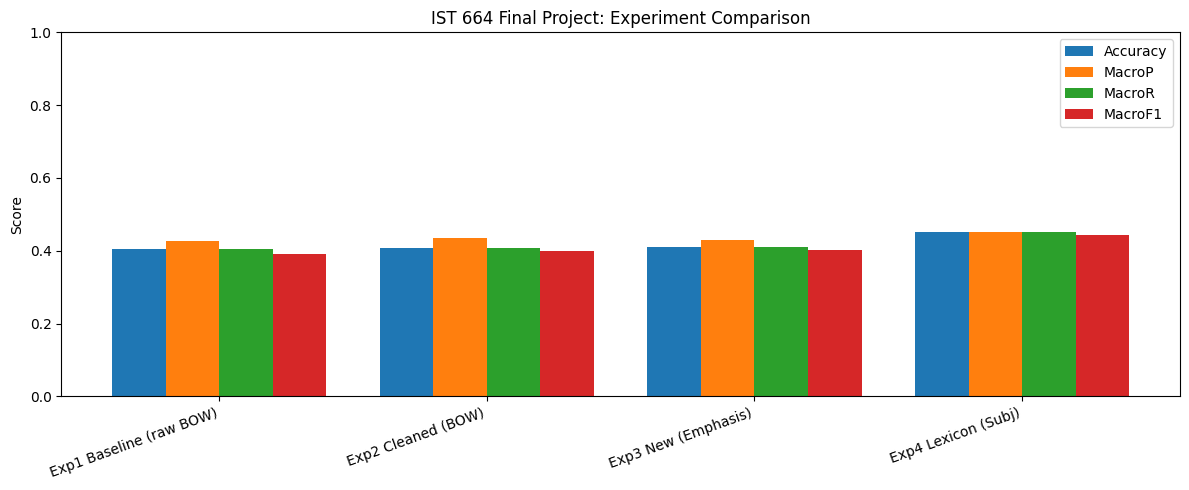

In [16]:
import numpy as np
import matplotlib.pyplot as plt

metrics = ["Accuracy", "MacroP", "MacroR", "MacroF1"]
x = np.arange(len(df_results["Experiment"]))
width = 0.2

plt.figure(figsize=(12, 5))
for i, m in enumerate(metrics):
    plt.bar(x + i*width, df_results[m].values, width, label=m)

plt.xticks(x + width*1.5, df_results["Experiment"].values, rotation=20, ha="right")
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("IST 664 Final Project: Experiment Comparison")
plt.legend()
plt.tight_layout()
plt.show()

Confusion Matrix Heatmap

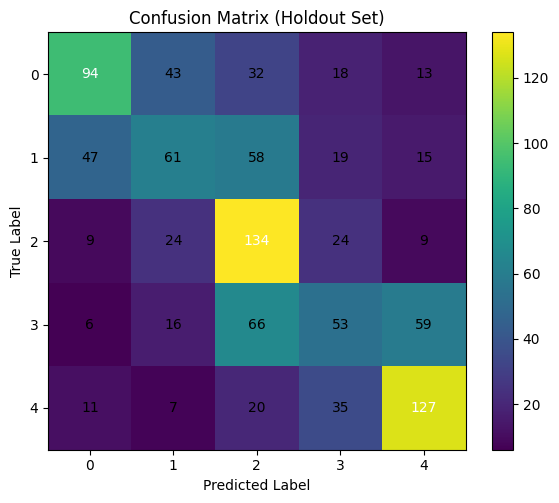

In [14]:
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import nltk

# pick your best feature function here:
BEST_FEATURE_FUNC = cleaned_plus_subjectivity_features  # or cleaned_plus_emphasis_features

X = [t for (t, lab) in examples]
y = [lab for (t, lab) in examples]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

train_set = [(BEST_FEATURE_FUNC(text), label) for text, label in zip(X_train, y_train)]
test_feats = [BEST_FEATURE_FUNC(text) for text in X_test]

clf = nltk.NaiveBayesClassifier.train(train_set)
y_pred = [clf.classify(f) for f in test_feats]

labels_sorted = sorted(set(y_test))
label_to_idx = {lab:i for i, lab in enumerate(labels_sorted)}
cm = np.zeros((len(labels_sorted), len(labels_sorted)), dtype=int)

for g, p in zip(y_test, y_pred):
    cm[label_to_idx[g], label_to_idx[p]] += 1

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation="nearest", cmap="viridis")
plt.title("Confusion Matrix (Holdout Set)")
plt.colorbar()
plt.xticks(range(len(labels_sorted)), labels_sorted)
plt.yticks(range(len(labels_sorted)), labels_sorted)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# write counts on the grid
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center", color="white" if cm[i, j] > cm.max()/2 else "black")

plt.tight_layout()
plt.show()

Top Informative Features

In [15]:
clf.show_most_informative_features(25)

Most Informative Features
 has_clean(performances) = True                4 : 1      =     26.3 : 1.0
              subj_score = 5.0                 4 : 2      =     23.0 : 1.0
         subj_strong_neg = 3.0                 0 : 2      =     22.3 : 1.0
        has_clean(would) = True                0 : 4      =     17.0 : 1.0
          has_clean(bad) = True                0 : 3      =     15.9 : 1.0
         has_clean(best) = True                4 : 2      =     15.7 : 1.0
        has_clean(great) = True                4 : 2      =     15.0 : 1.0
              subj_score = 4.0                 4 : 2      =     14.5 : 1.0
      has_clean(minutes) = True                0 : 4      =     14.3 : 1.0
         subj_strong_pos = 2.0                 4 : 2      =     13.3 : 1.0
          subj_pos_total = 3.0                 4 : 2      =     12.6 : 1.0
          subj_neg_total = 3.0                 0 : 2      =     12.3 : 1.0
              subj_score = -5.0                0 : 4      =     11.7 : 1.0